In [ ]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 30.6 MB/s 


**Download and Preprocesing the dataset**

In [ ]:

import pandas as pd
from numpy import savetxt

"""
data = pd.read_csv('processed data.csv')
data = data.values

# this code is for handling missing values
#data.replace('?', 'NaN', inplace=True)
col_mode = data.mode()
for i in data.columns:
  temp = col_mode[i][0]
  for j in data.index:
    if data.loc[j,i] == 'Unknown':
      data.loc[j,i] = temp

savetxt('processed data_modified.csv', data, delimiter=',', fmt='%s')
"""
data = pd.read_csv('processed data_modified.csv')
data = data.drop('hosp_yn',axis=1)
data.head(5)
data.mode()

,abdom_yn,abxchest_yn,age_group,chills_yn,cough_yn,death_yn,diarrhea_yn,fever_yn,headache_yn,icu_yn,mechvent_yn,nauseavomit_yn,pna_yn,race_ethnicity_combined,sex,sob_yn,sthroat_yn
0,No,Yes,80+ Years,No,Yes,Yes,No,Yes,No,Yes,No,No,Yes,"Black, Non-Hispanic",Male,Yes,No


In [ ]:
import pandas as pd
import numpy as np

from urllib.request import urlopen
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination

data = data.rename({"abdom_yn":"A","abxchest_yn":"B","age_group":"C","chills_yn":"D","cough_yn":"E","death_yn":"F","diarrhea_yn":"G","fever_yn":"H","headache_yn":"I","icu_yn":"K","mechvent_yn":"L","nauseavomit_yn":"M","pna_yn":"N","race_ethnicity_combined":"O","sex":"P","sob_yn":"Q","sthroat_yn":"R"}, axis='columns')
data.head()

,A,B,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R
0,No,Yes,20 - 29 Years,No,Yes,No,No,Yes,Yes,No,No,No,Yes,"Black, Non-Hispanic",Female,Yes,No
1,No,Yes,20 - 29 Years,No,No,Yes,No,No,No,Yes,No,No,Yes,"Black, Non-Hispanic",Female,No,No
2,No,Yes,20 - 29 Years,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Yes,"Black, Non-Hispanic",Female,No,No
3,No,Yes,20 - 29 Years,No,Yes,Yes,No,No,No,Yes,No,No,Yes,"Black, Non-Hispanic",Female,Yes,No
4,No,Yes,30 - 39 Years,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,"Black, Non-Hispanic",Female,Yes,No


### **Structure Learning begins here** 
###### Given a set of data samples, estimate a DAG that captures the dependencies between the variables
---
Score-based structure learning: Hill-Climb algorithm


In [ ]:
from pgmpy.estimators import HillClimbSearch, PC
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.factors.discrete.CPD import TabularCPD

k2 = K2Score(data)
bic = BicScore(data)

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())
print(k2.score(best_model))
print(bic.score(best_model))

Constraint-based structure learning: PC with variants algorithm

In [ ]:
est = PC(data)
#estimated_model = est.estimate(variant='orig', max_cond_vars=4)
estimated_model = est.estimate(variant='stable', ci_test='chi_square', max_cond_vars=17)
print(estimated_model.edges())

  0%|          | 0/17 [00:00<?, ?it/s]

Directed Acyclic Graph

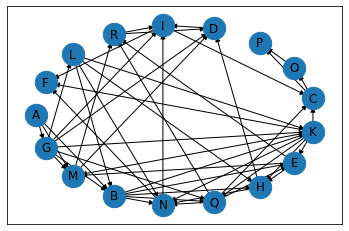

DiGraph with 17 nodes and 47 edges


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([ ('A', 'G'), ('A', 'M'), ('A', 'B'), ('B', 'N'), ('B', 'Q'), ('B', 'H'), ('B', 'E'), ('B', 'K'), ('C', 'O'), ('C', 'P'), ('D', 'I'), ('E', 'H'), ('E', 'M'), ('E', 'R'), ('G', 'D'), ('G', 'M'), ('G', 'L'), ('G', 'Q'), ('G', 'B'), ('G', 'K'), ('G', 'I'), ('H', 'D'), ('H', 'N'), ('I', 'C'), ('I', 'F'), ('K', 'Q'), ('K', 'C'), ('K', 'F'), ('K', 'N'), ('K', 'E'), ('K', 'M'), ('K', 'H'), ('L', 'K'), ('L', 'H'), ('L', 'B'), ('L', 'N'), ('M', 'D'), ('M', 'R'), ('N', 'I'), ('N', 'F'), ('O', 'P'), ('Q', 'E'), ('Q', 'C'), ('Q', 'N'), ('Q', 'R'), ('R', 'I'), ('R', 'D') ])
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
plt.show()
print (nx.info(G))

### **Parameter Learning begins here**
###### Parameter learning is the task to estimate the values of the conditional probability distributions (CPDs)
---
Get parameters from Bayesian Network

In [ ]:
model = BayesianNetwork([('A', 'G'), ('A', 'M'), ('A', 'B'), ('B', 'N'), ('B', 'Q'), ('B', 'H'), ('B', 'E'), ('B', 'K'), ('C', 'O'), ('C', 'P'), ('D', 'I'), ('E', 'H'), ('E', 'M'), ('E', 'R'), ('G', 'D'), ('G', 'M'), ('G', 'L'), ('G', 'Q'), ('G', 'B'), ('G', 'K'), ('G', 'I'), ('H', 'D'), ('H', 'N'), ('I', 'C'), ('I', 'F'), ('K', 'Q'), ('K', 'C'), ('K', 'F'), ('K', 'N'), ('K', 'E'), ('K', 'M'), ('K', 'H'), ('L', 'K'), ('L', 'H'), ('L', 'B'), ('L', 'N'), ('M', 'D'), ('M', 'R'), ('N', 'I'), ('N', 'F'), ('O', 'P'), ('Q', 'E'), ('Q', 'C'), ('Q', 'N'), ('Q', 'R'), ('R', 'I'), ('R', 'D')])
#model.fit(val_data, estimator=MaximumLikelihoodEstimator)
estimator = BayesianEstimator(model, data)
estimator.get_parameters(prior_type='BDeu', equivalent_sample_size=64)

[<TabularCPD representing P(A:2) at 0x7fbe98a8ac10>,
 <TabularCPD representing P(G:2 | A:2) at 0x7fbe98a83bb0>,
 <TabularCPD representing P(M:2 | A:2, E:2, G:2, K:2) at 0x7fbe98a6bbb0>,
 <TabularCPD representing P(B:2 | A:2, G:2, L:2) at 0x7fbe98a83cd0>,
 <TabularCPD representing P(N:2 | B:2, H:2, K:2, L:2, Q:2) at 0x7fbe98a83af0>,
 <TabularCPD representing P(Q:2 | B:2, G:2, K:2) at 0x7fbe96218370>,
 <TabularCPD representing P(H:2 | B:2, E:2, K:2, L:2) at 0x7fbe98a8a550>,
 <TabularCPD representing P(E:2 | B:2, K:2, Q:2) at 0x7fbe98a8ad00>,
 <TabularCPD representing P(K:2 | B:2, G:2, L:2) at 0x7fbe96218100>,
 <TabularCPD representing P(C:9 | I:2, K:2, Q:2) at 0x7fbe98a8a100>,
 <TabularCPD representing P(O:6 | C:9) at 0x7fbe96256340>,
 <TabularCPD representing P(P:2 | C:9, O:6) at 0x7fbe98a83ca0>,
 <TabularCPD representing P(D:2 | G:2, H:2, M:2, R:2) at 0x7fbe9624dfd0>,
 <TabularCPD representing P(I:2 | D:2, G:2, N:2, R:2) at 0x7fbe96218fa0>,
 <TabularCPD representing P(R:2 | E:2, M:2, Q

Get CPDs from Bayesian Network

In [ ]:
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=64)
#print(estimator.estimate_cpd('G', prior_type='BDeu', equivalent_sample_size=10))
for cpd in model.get_cpds():
  probs = cpd.values.tolist()
  probs = np.array(probs)
  all_row = []
  if(cpd.variable=='A'):
    pass
  else:
    for m in range(len(probs)):
      mcat = np.concatenate((probs[m]), axis=None)
      all_row.append(mcat.tolist())

    cpd = TabularCPD(cpd.variable, cpd.variable_card, np.round(all_row,2), evidence=cpd.variables[1:], evidence_card=cpd.cardinality[1:])
    print(cpd.state_names)

+------+------+------+
| A    | A(0) | A(1) |
+------+------+------+
| G(0) | 0.9  | 0.53 |
+------+------+------+
| G(1) | 0.1  | 0.47 |
+------+------+------+
+------+------+------+------+------+-----+------+------+------+------+------+
| A    | A(0) | A(0) | A(0) | A(0) | ... | A(1) | A(1) | A(1) | A(1) | A(1) |
+------+------+------+------+------+-----+------+------+------+------+------+
| E    | E(0) | E(0) | E(0) | E(0) | ... | E(0) | E(1) | E(1) | E(1) | E(1) |
+------+------+------+------+------+-----+------+------+------+------+------+
| G    | G(0) | G(0) | G(1) | G(1) | ... | G(1) | G(0) | G(0) | G(1) | G(1) |
+------+------+------+------+------+-----+------+------+------+------+------+
| K    | K(0) | K(1) | K(0) | K(1) | ... | K(1) | K(0) | K(1) | K(0) | K(1) |
+------+------+------+------+------+-----+------+------+------+------+------+
| M(0) | 0.91 | 0.94 | 0.94 | 0.97 | ... | 0.89 | 0.57 | 0.76 | 0.38 | 0.52 |
+------+------+------+------+------+-----+------+------+---

In [ ]:
# Getting all the local independencies in the network.
model.local_independencies(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R'])

(C ⟂ F, N, M, E, L, A, H, B, D, G, R | K, Q, I)
(D ⟂ A, K, Q, N, B, E, L | M, G, R, H)
(E ⟂ A, G, L | K, B, Q)
(F ⟂ O, C, M, E, L, A, P, Q, H, B, D, G, R | N, K, I)
(H ⟂ A, Q, G, M, R | K, B, E, L)
(I ⟂ K, M, E, L, A, Q, H, B | N, D, G, R)
(K ⟂ A | B, G, L)
(L ⟂ A | G)
(M ⟂ H, Q, N, B, L | A, K, G, E)
(N ⟂ A, G, D, M, R, E | K, Q, H, B, L)
(O ⟂ K, F, D, N, M, E, L, A, Q, H, B, G, R, I | C)
(P ⟂ K, F, N, M, E, L, A, Q, H, B, D, G, R, I | O, C)
(Q ⟂ A, L | K, B, G)
(R ⟂ A, K, H, N, B, G, L | M, E, Q)

Inference

In [ ]:
infer = VariableElimination(model)
q = infer.query(variables=['R'], evidence={'J': 'No', 'D': 'Yes', 'E': 'No'})
print(q)